In [1]:
import pandas as pd
import numpy as np
import requests
import os
import time
from datetime import datetime
import re
import yfinance as yf

In [2]:
#除了國定假日外的休市日期
no_trade_list_2022 = ['2022-01-01', '2022-01-03', '2022-01-27', '2022-01-28', '2022-01-31', '2022-02-01', '2022-02-02', 
    '2022-02-03', '2022-02-04', '2022-02-28', '2022-04-04', '2022-04-05', '2022-05-01', 
    '2022-05-02', '2022-06-03', '2022-09-09', '2022-09-10', '2022-10-10']

no_trade_list_2023 = ['2023-01-01', '2023-01-02', '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-21', '2023-01-22',
        '2023-01-23', '2023-01-24', '2023-01-25', '2023-01-26', '2023-01-27', '2023-02-27', '2023-02-28', '2023-04-03',
        '2023-04-04', '2023-04-05', '2023-05-01', '2023-06-22', '2023-06-23', '2023-09-29', '2023-10-09', '2023-10-10']

no_trade_list = no_trade_list_2022
no_trade_list.extend(no_trade_list_2023)

In [3]:
def volume_ranking(date, stock_name):
    try:
        route = '../finmind_data/' + date + '/' + stock_name + '_' + date + '.csv'
        data = pd.read_csv(route)
    except:
        print(date, stock_name, '無資料')
        return 0
    grouped = data.groupby('securities_trader_id')
    li = list(dict.fromkeys(data['securities_trader_id']))
    securities_name = []
    securities_share = []
    for n in li:
        globals()[stock_name + '_' + str(n)] = grouped.get_group(n)
        name = globals()[stock_name + '_' + str(n)].iloc[0]['securities_trader_id']
        share = globals()[stock_name + '_' + str(n)]['buy'].sum() + globals()[stock_name + '_' + str(n)]['sell'].sum()
        securities_name.append(name)
        securities_share.append(share)
    df = pd.DataFrame()
    df['證券商'] = securities_name
    df['總交易股數'] = securities_share
    volume = df.sort_values('總交易股數', ascending=False)
    volume['排名'] = range(1, len(volume)+1)
    return volume

In [4]:
# 找出所有符合條件的日期
# start_date、end_date尋找的日期
# no_trading_list 除了例假日以外無交易的日期清單
# stock_list : 所有股票的清單
# securities_name : 要回測的隔日沖分點

def find_all_date(start_date, end_date, no_trading_list, securities_name):
    summary = {}
    al = 0
    find = 0
    globals()['error'] = []
    all_date = pd.date_range(start_date, end_date ,freq='b')  #找出日期區間內周一至周五的日期
    for d in all_date:
        date = str(d).split(' ')[0]
        if date not in no_trading_list:  #all_date中的工作日扣除證交所公布的國定休市日
            s_list = []
            try:
                route = '../finmind_data/' + date + '/' + date + '漲停清單.csv'
                stock_list = pd.read_csv(route)
                stock_list = stock_list[stock_list['交易市場'] == '市']
            except:
                print(date, '無漲停清單資料')
                return 0
            for s in stock_list['代碼']:
                try:
                    df = volume_ranking(date, str(s))
                except:
                    globals()['error'].append([date, s, 'error'])
                    continue
                try:
                    br = df[df['證券商'] == securities_name]#買超第一名是目標分點securities_name
                    if br['排名'].iloc[0] <= 1:
                        al = al + 1
                        find = find + 1
                        s_list.append(s)
                except:
                    al = al + 1
                    continue
            summary[date] = s_list
            
        else:
            continue
    print('共有', al, '檔股票漲停', '其中' + securities_name + '交易量第一的有', find, '檔')
    return summary
            


In [5]:
train_dictionary = find_all_date('2022-02-07', '2022-10-31', no_trade_list, '9268')#9268是凱基台北的代號

共有 617 檔股票漲停 其中9268交易量第一的有 352 檔


In [7]:
test_dictionary = find_all_date('2022-11-01', '2023-02-02', no_trade_list, '9268')

2023-01-11 3701 無資料
2023-01-11 3443 無資料
2023-01-11 2498 無資料
2023-01-11 2364 無資料
2023-01-11 6796 無資料
2023-01-11 1512 無資料
2023-01-11 6799 無資料
2023-01-11 2482 無資料
2023-02-02 3588 無資料
2023-02-02 4956 無資料
共有 223 檔股票漲停 其中9268交易量第一的有 120 檔


In [6]:
#預測的因子 : 漲停當天的振幅、大盤當天的漲幅
#抓取資料

In [8]:
#用finmind api爬取大盤當天的漲跌幅
def TaiwanIndex_per(date, dataset):
    url = "https://api.finmindtrade.com/api/v4/data"
    parameter = {
        "dataset": dataset,
        "start_date": date,
        "token": "", # 參考登入，獲取金鑰
    }
    data = requests.get(url, params=parameter)
    data = data.json()
    data = pd.DataFrame(data['data'])
    open_price = data['TAIEX'][0]
    close_price = data['TAIEX'][len(data)-1]
    per = (close_price - open_price) / open_price *100
    return per

In [10]:
#計算股票在漲停隔天的報酬率
def stock_return(date, stock_id):  
    kbars = api.kbars(
        contract=api.Contracts.Stocks[stock_id], 
        start = date, 
        end = date, 
    )
    df = pd.DataFrame({**kbars})
    df.ts = pd.to_datetime(df.ts)
    open_price = df.iloc[0]['Open']
    close_price = df.iloc[-1]['Close']
    per = (close_price - open_price) / open_price *100
    return per

In [11]:
#整理 train、test data
def dictionary_process(dic):    
    key = list(dic.keys())
    todf = []
    for index in range(len(key)):
        if index == len(dic.keys()) - 1:
            break
        if len(dic[key[index]]) != 0:
            date = key[index]
            #大盤報酬
            TwIndex_percent = TaiwanIndex_per(key[index], "TaiwanVariousIndicators5Seconds")
            for s in dic[date]:
                #振幅
                if str(s) == '2364':
                    continue
                route = '../finmind_data/' + date + '/' + date + '漲停清單.csv'
                df = pd.read_csv(route)
                df = df[df['代碼'] == int(s)]
                wave = df['振幅(%)'].iloc[0]
                #個股隔天的實際報酬
                r = stock_return(key[index + 1], str(s))
                z = [s, wave, TwIndex_percent ,r]
                todf.append(z)
        print(index, key[index], '完成')
    return todf

In [16]:
train_data = dictionary_process(train_dictionary)

0 2022-02-07 完成
1 2022-02-08 完成
2 2022-02-09 完成
3 2022-02-10 完成
4 2022-02-11 完成
5 2022-02-14 完成
6 2022-02-15 完成
7 2022-02-16 完成
8 2022-02-17 完成
9 2022-02-18 完成
10 2022-02-21 完成
11 2022-02-22 完成
12 2022-02-23 完成
13 2022-02-24 完成
14 2022-02-25 完成
15 2022-03-01 完成
16 2022-03-02 完成
17 2022-03-03 完成
18 2022-03-04 完成
19 2022-03-07 完成
20 2022-03-08 完成
21 2022-03-09 完成
22 2022-03-10 完成
23 2022-03-11 完成
24 2022-03-14 完成
25 2022-03-15 完成
26 2022-03-16 完成
27 2022-03-17 完成
28 2022-03-18 完成
29 2022-03-21 完成
30 2022-03-22 完成
31 2022-03-23 完成
32 2022-03-24 完成
33 2022-03-25 完成
34 2022-03-28 完成
35 2022-03-29 完成
36 2022-03-30 完成
37 2022-03-31 完成
38 2022-04-01 完成
39 2022-04-06 完成
40 2022-04-07 完成
41 2022-04-08 完成
42 2022-04-11 完成
43 2022-04-12 完成
44 2022-04-13 完成
45 2022-04-14 完成
46 2022-04-15 完成
47 2022-04-18 完成
48 2022-04-19 完成
49 2022-04-20 完成
50 2022-04-21 完成
51 2022-04-22 完成
52 2022-04-25 完成
53 2022-04-26 完成
54 2022-04-27 完成
55 2022-04-28 完成
56 2022-04-29 完成
57 2022-05-03 完成
58 2022-05-04 完成
59 2022

In [17]:
test_data = dictionary_process(test_dictionary)

0 2022-11-01 完成
1 2022-11-02 完成
2 2022-11-03 完成
3 2022-11-04 完成
4 2022-11-07 完成
5 2022-11-08 完成
6 2022-11-09 完成
7 2022-11-10 完成
8 2022-11-11 完成
9 2022-11-14 完成
10 2022-11-15 完成
11 2022-11-16 完成
12 2022-11-17 完成
13 2022-11-18 完成
14 2022-11-21 完成
15 2022-11-22 完成
16 2022-11-23 完成
17 2022-11-24 完成
18 2022-11-25 完成
19 2022-11-28 完成
20 2022-11-29 完成
21 2022-11-30 完成
22 2022-12-01 完成
23 2022-12-02 完成
24 2022-12-05 完成
25 2022-12-06 完成
26 2022-12-07 完成
27 2022-12-08 完成
28 2022-12-09 完成
29 2022-12-12 完成
30 2022-12-13 完成
31 2022-12-14 完成
32 2022-12-15 完成
33 2022-12-16 完成
34 2022-12-19 完成
35 2022-12-20 完成
36 2022-12-21 完成
37 2022-12-22 完成
38 2022-12-23 完成
39 2022-12-26 完成
40 2022-12-27 完成
41 2022-12-28 完成
42 2022-12-29 完成
43 2022-12-30 完成
44 2023-01-03 完成
45 2023-01-04 完成
46 2023-01-05 完成
47 2023-01-06 完成
48 2023-01-09 完成
49 2023-01-10 完成
50 2023-01-11 完成
51 2023-01-12 完成
52 2023-01-13 完成
53 2023-01-16 完成
54 2023-01-17 完成
55 2023-01-30 完成
56 2023-01-31 完成
57 2023-02-01 完成


In [26]:
#將蒐集到的資料整理成x_train、y_train、x_test、y_test
train_data = pd.DataFrame(train_data, columns = ['股票代碼', '振幅', '加權指數報酬', '預測報酬(y)'])
x_train = train_data.drop(['股票代碼','預測報酬(y)'], axis = 1)
y_train = train_data.drop(['股票代碼','振幅', '加權指數報酬'], axis = 1)
for i in range(len(y_train)):
    if y_train['預測報酬(y)'].iloc[i] > 0:
        y_train.loc[i, '預測報酬(y)'] = 1
    else:
        y_train.loc[i, '預測報酬(y)'] = 0

test_data = pd.DataFrame(test_data, columns = ['股票代碼', '振幅', '加權指數報酬', '預測報酬(y)'])
x_test = test_data.drop(['股票代碼', '預測報酬(y)'], axis = 1)
y_test = test_data.drop(['股票代碼', '振幅', '加權指數報酬'], axis = 1)
for i in range(len(y_test)):
    if y_test['預測報酬(y)'].iloc[i] > 0:
        y_test.loc[i, '預測報酬(y)'] = 1
    else:
        y_test.loc[i, '預測報酬(y)'] = 0

In [27]:
x_test.head()

,振幅,加權指數報酬
0,3.99,0.675380
1,1.78,0.675380
2,2.46,0.482925
3,11.60,-0.866935
4,6.07,0.308857


In [28]:
y_test.head()# 將預期報酬為正的欄位改成1，表示應該做多，0則表示預期報酬為負，應該做空

,預測報酬(y)
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0


In [29]:
#建立模型
#以 x_train、y_train訓練模型、x_test、y_test測試模型，並輸出在測試資料預測的準確率
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
print(xgbc.score(x_test, y_test)) #此模型預測test data的正確率

0.6224489795918368


In [41]:
#抓取某日個股的一分K線資料
def stock_one_min_kbar(date, stock_id):  
    kbars = api.kbars(
        contract=api.Contracts.Stocks[stock_id], 
        start = date, 
        end = date, 
    )
    df = pd.DataFrame({**kbars})
    df.ts = pd.to_datetime(df.ts)
    df_arr = np.array(df)
    return df_arr

In [40]:
stock_one_min_kbar('2022-11-01', '1101').head()

,ts,Close,Low,High,Volume,Open,Amount
0,2022-11-01 09:01:00,30.20,30.1,30.25,507,30.25,15315350.0
1,2022-11-01 09:02:00,30.25,30.2,30.25,36,30.20,1087400.0
2,2022-11-01 09:03:00,30.25,30.2,30.25,98,30.20,2961000.0
3,2022-11-01 09:04:00,30.25,30.2,30.25,53,30.20,1602750.0
4,2022-11-01 09:05:00,30.20,30.2,30.25,30,30.25,906450.0


In [45]:
stock_one_min_kbar('2022-11-01', '1101')[0, 1]

30.2

In [31]:
#抓取個股某日的收盤報價
def stock_close_price(date, stock):
    kbars = api.kbars(
        contract=api.Contracts.Stocks[stock], 
        start = date, 
        end = date, 
    )
    df = pd.DataFrame({**kbars})
    df.ts = pd.to_datetime(df.ts)
    close = df['Close'].iloc[-1]
    return close

In [46]:
#回測績效
principal = 1000000 #本金
BS = None
buy = {}#紀錄做多的時間點
sell = {}#紀錄做多平倉的時間點
sellshort = {}#紀錄做空的時間點
buytocover = {}#紀錄做空後平倉的時間點
profit_list_realized = [] 
profit_fee_list_realized = [] #扣掉交易稅後的已實現損益
fee_rate = 0.003 #手續費加交易稅大約千分之3
date = [] #紀錄所有交易日
c = 0
predict_y = xgbc.predict(x_test)  #先把testing data的預測Y值都算出來
T = list(test_dictionary.keys()) #所有交易日期的清單
for date_index in range(len(T)): #日期
    if date_index == len(test_dictionary.keys()) - 1:
            break
    if len(test_dictionary[T[date_index]]) != 0: #確認該日期內至少有交易一檔股票
        day = T[date_index].replace('-', '_')
        globals()['buy_' + day] = []
        globals()['sellshort_' + day] = []
        globals()['sell_' + day] = []
        globals()['buytocover_' + day] = []
        allday_profit = 0
        allday_profit_fee = 0
        for stock in test_dictionary[T[date_index]]: #個股
            if str(stock) == '2364':
                continue
            stock = str(stock) 
            df_arr = stock_one_min_kbar(T[date_index], stock)
            #抓取個股tick資料
            for i in range(len(df_arr)):
                if i == len(df_arr)-1:
                    break
              #i == 0 時會以前面建立的模型判斷的結果在持倉為None的情況下決定要以開盤價做多或做空
                if i == 0:  
                    #先抓出前一日收盤價，以利停利停損計算
                    if str(T[date_index]) == '2022-11-01':
                        close_yesterday = stock_close_price('2022-10-31', stock)  #第一天沒有前面的資料所以手動補上10/31
                    else:
                        close_yesterday = stock_close_price(T[date_index-1], stock)  #除第一個交易日以外都是抓出前一日收盤價
                    
                    #做多邏輯
                    if predict_y[c] == 1: #做多
                        money = 1000 * (df_arr[i, 5]) #開盤價買入成本
                        BS = 'B'
                        t = i + 1
                        globals()['buy_' + day].append(stock + '_' + str(t))
                    #做空邏輯
                    elif predict_y[c] == 0:#做空
                        money = 1000 * (df_arr[i, 5])
                        BS = 'S'
                        t = i + 1
                        globals()['sellshort_' + day].append(stock + '_' + str(t))
                    #先抓出前一日收盤價，以利停利停損計算
                    if str(T[date_index]) == '2022-11-01':
                        close_yesterday = stock_close_price('2022-10-31', stock)  #第一天沒有前面的資料
                    else:
                        close_yesterday = stock_close_price(T[date_index-1], stock)  #除第一個交易日以外都是抓出前一日收盤價
                    continue

                #從i == 1的迴圈開始，在算損益前都會先判斷這檔個股的持倉是否已經為0
                # (因為此策略設計在i == 0也就是開盤第16分鐘時做多或做空後，一但停利或停損這檔股票在當天就不會再交易了 )
                if BS == None: 
                    break #若持倉已經為None，則可以直接進入下一檔股票了
                #停利停損邏輯
                #以前一日收盤價計算停利停損點
                elif BS == 'B':
                    stopLoss = df_arr[i, 1] <= close_yesterday * 0.95   #前一天收盤價下跌5%停損
                    stopProfit = df_arr[i, 1] >= close_yesterday * 1.09 #前一天收盤價上漲9%停利
                    
                    profit = 1000 * (df_arr[i+1, 5] - df_arr[0, 5]) #每張股票1000股乘以由第i+1分鐘的開盤價減第i分鐘的開盤價的值

                    if stopLoss or stopProfit or i == len(df_arr) - 3: #如果13:24還沒平倉，則在13:25以open的價格平倉
                        new_money = 1000 * (df_arr[i+1, 5])
                        profit_fee = profit - money * fee_rate - new_money * fee_rate
                        allday_profit_fee = allday_profit_fee + profit_fee
                        Time = i+1
                        globals()['sell_' + day] .append(stock + '_' + str(Time))
                        BS = None

                    else:
                        continue #若未平倉，則不計算損益
                elif BS == 'S':
                    stopLoss = df_arr[i, 1] >= close_yesterday * 1.05   #前一天收盤價上漲5%停損
                    stopProfit = df_arr[i, 1] <= close_yesterday * 0.91 #前一天收盤價下跌9%停利
                    
                    profit = 1000 * (df_arr[0, 5] - df_arr[i+1, 5]) #每張股票1000股乘以由第i分鐘的開盤價減第(i+1)分鐘的開盤價的值

                    if stopLoss or stopProfit or i == len(df_arr) - 3: #如果13:24還沒平倉，則在13:25以open的價格平倉
                        
                        new_money = 1000 * (df_arr[i+1, 5])
                        profit_fee = profit - money * fee_rate - new_money * fee_rate
                        allday_profit_fee = allday_profit_fee + profit_fee
                        Time = i+1
                        globals()['buytocover_' + day].append(stock + '_' + str(Time))
                        BS = None

                    else:
                        continue
            c = c+ 1
        date.append(T[date_index])
        profit_list_realized.append(allday_profit)
        profit_fee_list_realized.append(allday_profit_fee)                    
        buy[T[date_index]] = globals()['buy_' + day]
        sell[T[date_index]] = globals()['sell_' + day] 
        buytocover[T[date_index]] = globals()['buytocover_' + day]
        sellshort[T[date_index]] = globals()['sellshort_' + day]
        print(T[date_index], '完成')
    

2022-11-01 完成
2022-11-02 完成
2022-11-03 完成
2022-11-04 完成
2022-11-07 完成
2022-11-08 完成
2022-11-09 完成
2022-11-10 完成
2022-11-11 完成
2022-11-14 完成
2022-11-15 完成
2022-11-16 完成
2022-11-17 完成
2022-11-18 完成
2022-11-21 完成
2022-11-22 完成
2022-11-23 完成
2022-11-24 完成
2022-11-25 完成
2022-11-28 完成
2022-11-29 完成
2022-11-30 完成
2022-12-02 完成
2022-12-05 完成
2022-12-06 完成
2022-12-07 完成
2022-12-08 完成
2022-12-09 完成
2022-12-12 完成
2022-12-13 完成
2022-12-14 完成
2022-12-15 完成
2022-12-16 完成
2022-12-19 完成
2022-12-20 完成
2022-12-21 完成
2022-12-22 完成
2022-12-23 完成
2022-12-26 完成
2022-12-27 完成
2022-12-28 完成
2022-12-29 完成
2022-12-30 完成
2023-01-03 完成
2023-01-04 完成
2023-01-05 完成
2023-01-06 完成
2023-01-09 完成
2023-01-10 完成
2023-01-12 完成
2023-01-16 完成
2023-01-30 完成
2023-01-31 完成
2023-02-01 完成


In [47]:
final_df = pd.DataFrame({'Date':date, 'Profit_fee_list_realized':profit_fee_list_realized})
final_df.head()

,Date,Profit_fee_list_realized
0,2022-11-01,-1860.15
1,2022-11-02,-83.05
2,2022-11-03,54336.50
3,2022-11-04,4734.50
4,2022-11-07,-254.80


In [48]:
final_df['principal'] = 1000000 + final_df['Profit_fee_list_realized'].cumsum()
final_df['high'] = final_df['principal'].cummax()
final_df['dd'] = ((final_df['principal'] - final_df['high']))/final_df['high']
final_df.head()

,Date,Profit_fee_list_realized,principal,high,dd
0,2022-11-01,-1860.15,998139.85,998139.85,0.000000
1,2022-11-02,-83.05,998056.80,998139.85,-0.000083
2,2022-11-03,54336.50,1052393.30,1052393.30,0.000000
3,2022-11-04,4734.50,1057127.80,1057127.80,0.000000
4,2022-11-07,-254.80,1056873.00,1057127.80,-0.000241


In [49]:
import matplotlib.pyplot as plt

In [52]:
def plot(data, name) :

    #new equity high
    eh = data[['Date', 'high']]
    eh = eh.drop_duplicates('high', keep = 'first')
                            
    fig = plt.figure(figsize=(20, 10)) 
    plt.subplot(2, 1, 1)
    plt.grid(color = 'white')
    plt.title('{} Return&MDD'.format(name),fontsize=20)
    plt.plot(data['Date'], data['principal'], color = 'red')
    plt.plot(eh['Date'], eh['high'],'o',color = 'limegreen', alpha = 0.5)
    plt.legend(['Gain' , 'New equity high'], loc = 'best')
    plt.gcf().autofmt_xdate()
    
    plt.subplot(2, 1, 2)
    plt.grid(color = 'white')
    plt.fill_between(data['Date'], data['dd'], interpolate=True, color='red')
    plt.legend(['dd'], loc = 'upper left')
    plt.gcf().autofmt_xdate()
    plt.show()

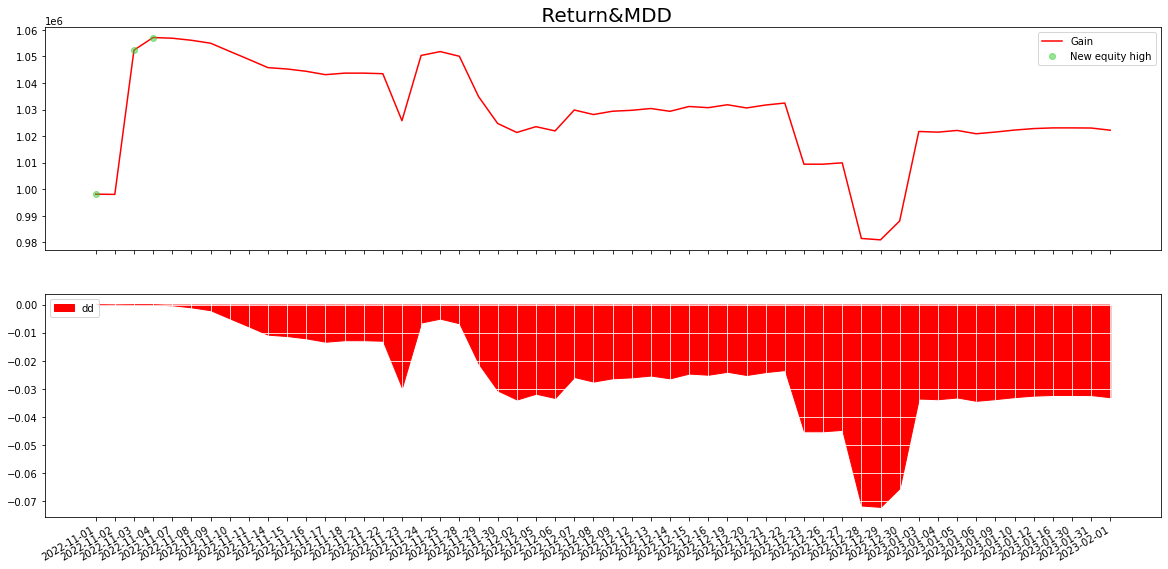

In [53]:
plot(final_df, '')

In [55]:
#2022/12/23、2022/12/28賠最多錢
final_df['profit_fee賠錢排名'] = final_df.Profit_fee_list_realized.rank(method='first',ascending=True)
final_df

,Date,Profit_fee_list_realized,principal,high,dd,profit_fee賠錢排名
0,2022-11-01,-1860.15,998139.85,998139.85,0.000000,10.0
1,2022-11-02,-83.05,998056.80,998139.85,-0.000083,28.0
2,2022-11-03,54336.50,1052393.30,1052393.30,0.000000,54.0
3,2022-11-04,4734.50,1057127.80,1057127.80,0.000000,49.0
4,2022-11-07,-254.80,1056873.00,1057127.80,-0.000241,25.0
5,2022-11-08,-781.30,1056091.70,1057127.80,-0.000980,21.0
6,2022-11-09,-1095.85,1054995.85,1057127.80,-0.002017,17.0
7,2022-11-10,-3066.30,1051929.55,1057127.80,-0.004917,8.0
8,2022-11-11,-3040.60,1048888.95,1057127.80,-0.007794,9.0
9,2022-11-14,-3099.00,1045789.95,1057127.80,-0.010725,7.0


In [62]:
#2022-12-23 做空兩檔股票(後面的數字是在第?根K棒做的操作)
sellshort['2022-12-23']

['3701_1', '3443_1']

In [63]:
#輸出回補的股票以及回補的時間點
buytocover['2022-12-23']

['3701_61', '3443_234']

In [65]:
#把當天的股價圖畫出來
import mplfinance as mpf
def stock_price_picture(date, stock_id, BS, time1, time2):  
    kbars = api.kbars(
        contract=api.Contracts.Stocks[stock_id], 
        start = date, 
        end = date, 
    )
    df = pd.DataFrame({**kbars})
    df.ts = pd.to_datetime(df.ts)
    df_index = df.set_index('ts')
    stock_id = str(stock_id)
    mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
    s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
    if BS == 'B':
        stock_id = stock_id + '  ' + '(Buy at:' + str(df['ts'].iloc[time1]) +' ' + 'Sell at:' + str(df['ts'].iloc[time2]) +')'
    elif BS == 'S':
        stock_id = stock_id + '  ' + '(Sell at:' + str(df['ts'].iloc[time1]) + ' ' + 'Buy at:' + str(df['ts'].iloc[time2]) + ')'
    kwargs = dict(type='line', volume = True,figsize=(10, 5),title = stock_id, style=s)
    mpf.plot(df_index, **kwargs)
    

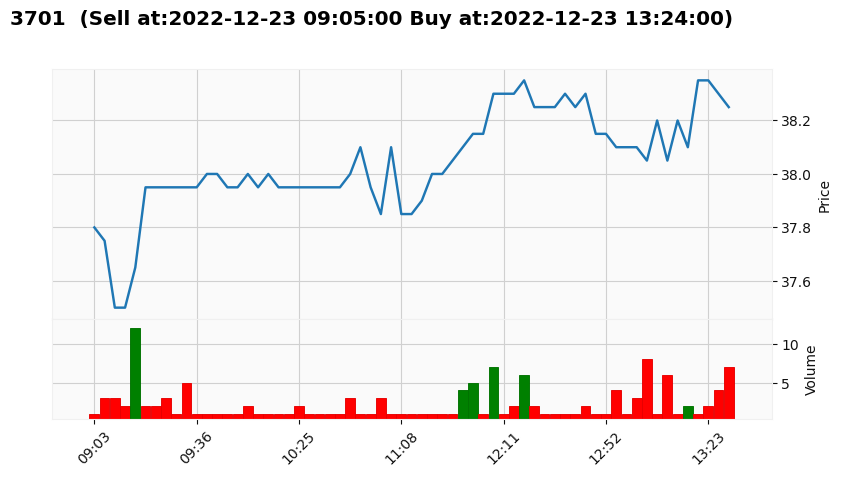

In [66]:
stock_price_picture('2022-12-23', '3701', 'S', 1, 61)

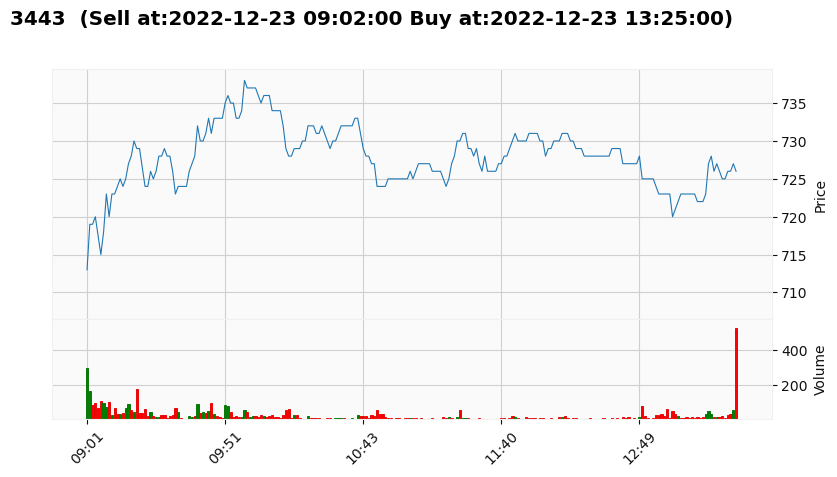

In [67]:
stock_price_picture('2022-12-23', '3443', 'S', 1, 234)

In [68]:
buy['2022-12-28']

['2498_1', '3443_1']

In [69]:
sell['2022-12-28']

['2498_256', '3443_12']

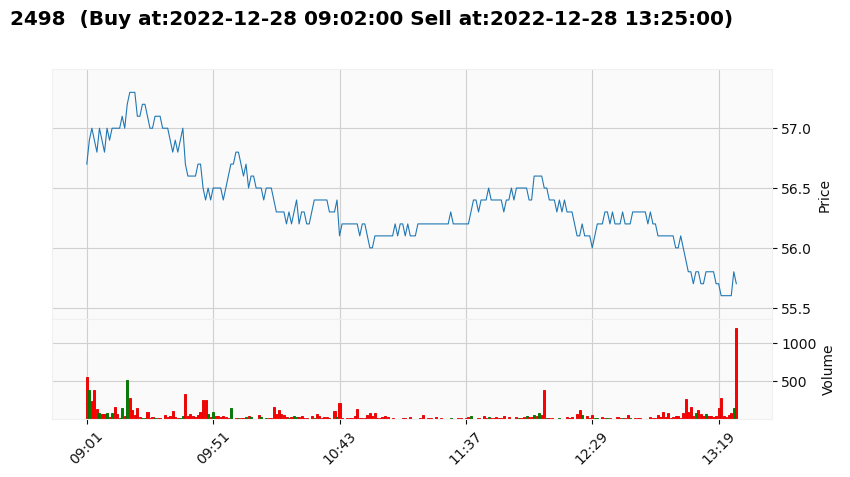

In [70]:
stock_price_picture('2022-12-28', '2498', 'B', 1, 256)

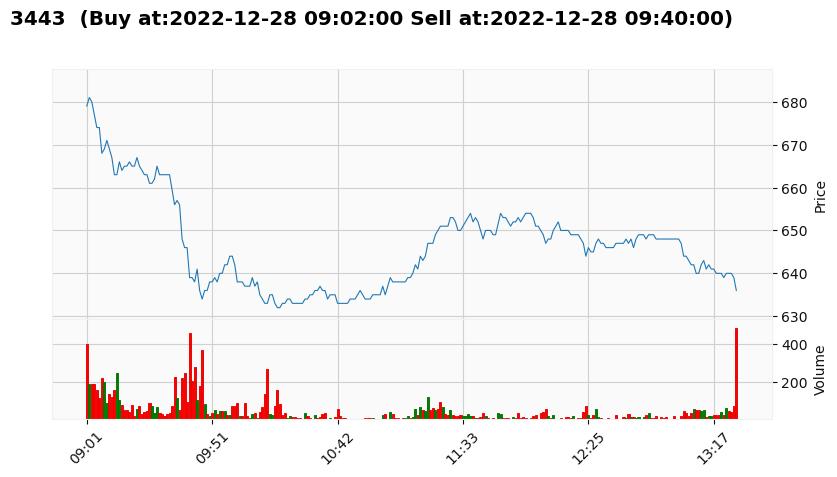

In [71]:
stock_price_picture('2022-12-28', '3443', 'B', 1, 39)

In [72]:
buy['2022-11-23']

['2498_1', '3443_1']

In [73]:
sell['2022-11-23']

['2498_260', '3443_263']

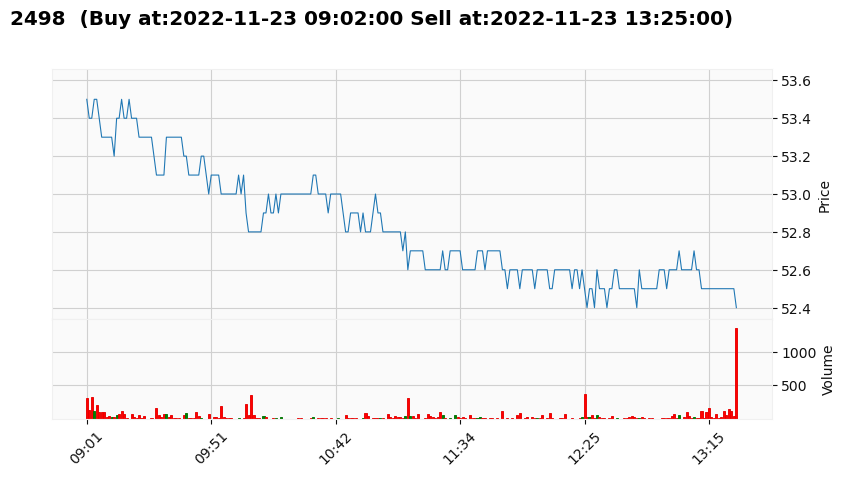

In [74]:
stock_price_picture('2022-11-23', '2498', 'B', 1, 260)

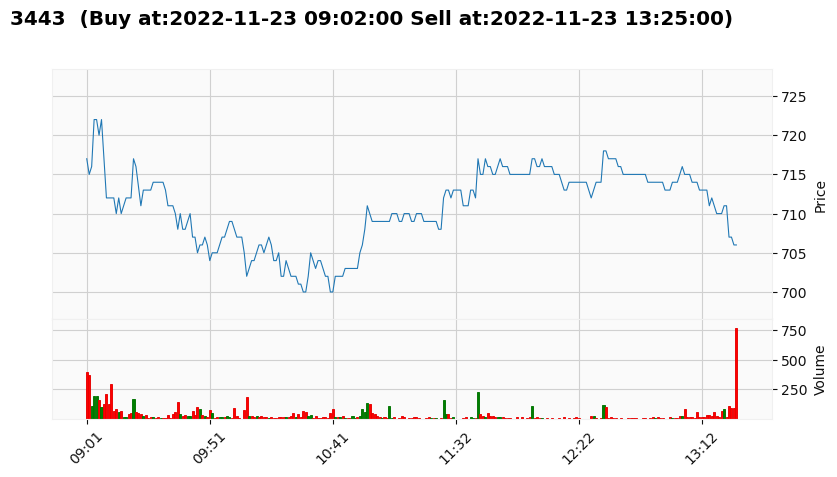

In [75]:
stock_price_picture('2022-11-23', '3443', 'B', 1, 263)